# Filter cells+positions+variants using thresholds

Saving as: 
1) NT pileup format for mgatk, similar to the input
2) Filtered af_by_cell matrix. This may not get used b/c we will call variants with mgatk later, but nice to have
3) Sparse matrices of Depth + allele frequency. These could be used for vireo. 

Create a function to convert between NT pileup and sparse matrices.

### Filter parameters

In [1]:
min_cells=50
min_reads=100

cell_coverage_thresh = 0
topN=0

min_het_cells=50
het_thresh=0.02
het_counts_thresh = 10


bq_thresh=30

In [2]:
num_proc=12

In [3]:
import os
import time
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
#ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571


import numpy as np

Project Directory: /data2/mito_lineage


In [4]:
from src.calculate_AF_by_cell import *
%load_ext autoreload
%autoreload 2

In [5]:
indir=join(RESULTS,"mttrace")
mapq = "mapq_0"
num_reads = 200
cellr="True"
in_prefix = f'2020_11_18'
pbmc_j = "PBMC_J"
pbmc_p = "PBMC_P"

pbmc_j_indir = join(indir, in_prefix, pbmc_j,mapq,f"cellr_{cellr}")
pbmc_p_indir = join(indir, in_prefix, pbmc_p,mapq,f"cellr_{cellr}")

concat_pbmc_j_dir = join(pbmc_j_indir,f"{pbmc_j}_{num_reads}")
concat_pbmc_p_dir = join(pbmc_p_indir,f"{pbmc_p}_{num_reads}")


In [6]:
from src.utils.parse_config import read_config_file
config = read_config_file(join(ROOT_DIR, "parameters/2020_11_18_Croker_mito.yaml"))
mt_ref_fa = config['mt_ref_fa']
config

{'samples': 'parameters/2020_11_18_Croker_mito.csv',
 'results': 'data/processed/mttrace/2020_11_18',
 'figures': 'figures/mttrace/2020_11_18',
 'main': ['mtscATAC'],
 'use_cellr_barcode': [True],
 'num_reads_filter': [200],
 'mito_character': 'chrM',
 'maxBP': 16571,
 'mapq': [0],
 'ref_fa': '/data2/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.fa',
 'mt_ref_fa': '/data2/mito_lineage/data/external/GRCh38_MT_blacklist/chrM.fasta',
 'min_cells': [100, 500, 10],
 'min_reads': [100],
 'top_cells': [0],
 'top_pos': [0],
 'cell_mt_coverage': [10, 100],
 'position_bq_thresh': [0, 'Gaussian']}

## Run for PBMC J

In [7]:
concat_dir = concat_pbmc_j_dir

In [8]:
# 0. Create stats df
stats = pd.DataFrame(columns=["# Cells", "# Positions", "# Variants"])

In [9]:
# 1. Load the MTPos pileup matrix, take the average of the +/- strands
sc_coverage = load_sc_pileup(join(concat_dir, "*.coverage.strands.txt.gz"))
stats = stats.append(pd.DataFrame([[len(sc_coverage["Cell"].unique()), max(sc_coverage["Position"]), 0]],
                          columns=["# Cells", "# Positions", "# Variants"],
                          index=["Initial 10x barcodes"]))
stats

,# Cells,# Positions,# Variants
Initial 10x barcodes,735,16569,0


In [10]:
# 2. Filter A: top cells by coverage, minimum coverage, minimum number of cells and certain number of reads
pos_counts_filter, cell_filter = filter_positions_cells(sc_coverage, topN=topN, min_cells=min_cells,
                       min_reads=min_reads)

stats = stats.append(pd.DataFrame([[len(cell_filter), len(pos_counts_filter), 0]],
                          columns=["# Cells", "# Positions", "# Variants"],
                          index=[f"Depth thresh: topN {topN} min_cells {min_cells} min_reads {min_reads}"]))
if len(cell_filter) == 0 or len(pos_counts_filter) == 0:
    print("Nothing passes the filter.")
stats

topN 0
Initial cells: 735
 Number of cells passed: 650
cell gauss 650
Number of positions to keep : 16568
Number of cells to keep : 650


,# Cells,# Positions,# Variants
Initial 10x barcodes,735,16569,0
Depth thresh: topN 0 min_cells 50 min_reads 100,650,16568,0


In [11]:
import seaborn as sns
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [12]:
# 3. Get the nt position info from filtered cells and variants.
nt_df, bq_df, cell_names = get_nt_bq(concat_dir, maxBP, cell_inds=cell_filter,
                                     nt_pos=pos_counts_filter)
nt_df

Not saving, need an out_d and name. Only returning nt_pileup.
Not saving, need an out_d and name. Only returning nt_pileup.
Not saving, need an out_d and name. Only returning nt_pileup.
Not saving, need an out_d and name. Only returning nt_pileup.


,A,C,G,T
1,1.0,45.0,47782.0,3.0
2,49583.0,3.0,6.0,0.0
3,16.0,16.0,0.0,53648.0
4,0.0,53929.0,14.0,1.0
5,54296.0,0.0,1.0,0.0
...,...,...,...,...
16565,3.0,68056.0,0.0,4.0
16566,4.0,0.0,64522.0,1.0
16567,63923.0,0.0,10.0,4.0
16568,1.0,16.0,15.0,62673.0


In [13]:
# 4. Get the highest alt allele, store in af, which is the filtered AF Pos-by-[AF, BQ] df
af = extract_af(nt_df, bq_df, mt_ref_fa, maxBP)
af

no alt count 3


,Nucleotide,AF,Reference,Alternative BQ,Depth
1,C,0.000940891,G,35.5958,47827
2,G,0.000120995,A,28.35,49589
3,A,0.000298151,T,33.6714,53664
4,G,0.000259533,C,33.625,53943
5,G,1.84172e-05,A,37,54297
...,...,...,...,...,...
16564,G,0.000160528,A,30.5,68524
16565,T,5.87717e-05,C,37,68060
16566,A,6.19905e-05,G,34,64526
16567,G,0.000156414,A,33,63933


In [14]:
# num_proc=12

# import src.calculate_AF_by_cell as cabc

In [15]:
# # 5.1 Create the nt_pileup filter, and initialize the variant-by-cell dataframes to be used
# nt_pileup = load_and_filter_nt_pileups(concat_dir, cell_filter, pos_counts_filter,
#                            out_d=None, name=None, incl_cov=True)
# pos_by_cell = pd.DataFrame(
#     index=af.apply(lambda x: (str(x.name) + x["Nucleotide"]),
#                    axis=1).values, columns=cell_names).transpose()

Text(0, 0.5, 'Number of variants')

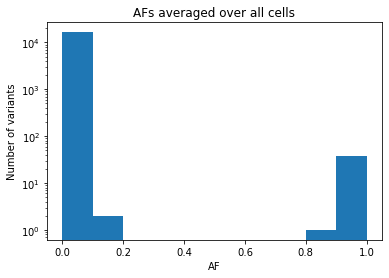

In [16]:
plt.hist((af["AF"]).astype(float))
plt.yscale('log')
plt.title("AFs averaged over all cells")
plt.xlabel('AF')
plt.ylabel("Number of variants")

In [17]:
# 5. Now that we called our alternate alleles, put them in
#    cell-allele sparse form (no 0s), extracting from the sparse
#    nucleotide pileups
af_nt_pileup = {}
for n, curr_af in af.groupby("Nucleotide"):
    print(n)
    print(curr_af.head())
    var_pos_to_keep = curr_af.index.unique()
    
    curr_f = glob.glob(os.path.join(concat_dir, f"*.{n}.strands.txt.gz"))[0]
    df = pd.read_csv(curr_f)
    # Only take the Forward reads since it is the one to compare against the reference
    if len(df.columns)>4:
        df.columns = ["Position", "Cell", "Coverage", "BQ", "- Coverage", "- BQ"]
        #df = df.iloc[:, :4]
    else:
        df.columns = ["Position", "Cell", "Coverage", "BQ"]
    df["Cell"] = df["Cell"].apply(lambda x: x.replace(".bam", ""))
    
    #########
    df = df[df["Cell"].isin(cell_names)]
    df = df[df["Position"].isin(var_pos_to_keep)]
    df["NT"] = n
    #########
    af_nt_pileup[n] = df
    
cov = load_sc_pileup(os.path.join(concat_dir, f"*.coverage.strands.txt.gz"))
cov = cov[cov["Cell"].isin(cell_names)]
cov = cov[cov["Position"].isin(af.index)]
af_sparse_df = pd.concat(af_nt_pileup.values(), axis=0)
af_sparse_df

af_sparse_df = af_sparse_df.rename({"Coverage": "Allele Depth" }, axis=1)

cov_ad = pd.merge(af_sparse_df, cov, how='inner', on=["Position", "Cell"])
cov_ad["ID"] = cov_ad.apply(lambda x: (str(x["Position"]) + x["NT"]), axis=1)

cov_ad["AF"] = cov_ad["Allele Depth"]/cov_ad["Coverage"]

A
   Nucleotide           AF Reference Alternative BQ  Depth   ID
3           A  0.000298151         T        33.6714  53664   3A
9           A  7.51959e-05         G           35.5  66493   9A
10          A  0.000355345         T        30.3571  67540  10A
11          A  0.000128516         C        15.3333  70030  11A
18          A  0.000326533         C         15.975  82687  18A
C
   Nucleotide           AF Reference Alternative BQ  Depth   ID
1           C  0.000940891         G        35.5958  47827   1C
12          C  0.000455218         T        33.3077  70296  12C
14          C  0.000429732         T        36.9235  72138  14C
20          C  0.000258573         T        32.5294  92817  20C
22          C  7.26722e-05         T        30.6667  96323  22C
G
   Nucleotide           AF Reference Alternative BQ  Depth   ID
2           G  0.000120995         A          28.35  49589   2G
4           G  0.000259533         C         33.625  53943   4G
5           G  1.84172e-05        

In [18]:
af_by_cell = cov_ad.pivot(index="Cell", columns="ID", values="AF").fillna(0)
ad_by_cell = cov_ad.pivot(index="Cell", columns="ID", values="Allele Depth").fillna(0)
ad_by_cell

ID,10000T,10001C,10002G,10003C,10004G,10005T,10006T,10007C,10008G,10009T,...,9993A,9994A,9995A,9996A,9997C,9998C,9999C,999A,99C,9A
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAGTGTCCCAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACTGCGTAGCGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGATGAGTCCGGAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGATGCAGGGCTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGATAGCAGGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACGTGTCACAGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTACGTGTCCGCTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGAGGGTTTGTAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


## Calculate AF by converting to dense

In [19]:
het_filt = filter_allele_cells(af_by_cell, het_thresh, min_het_cells=min_het_cells)


Positions that pass het filter: 47


Positions that pass het filter: 47


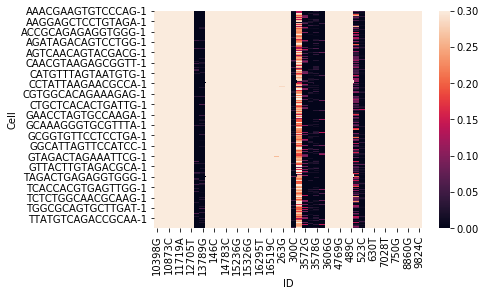

In [20]:
# 6. FILTER B: minimum cells w heterozygous AF minimum
het_filt = filter_allele_cells(af_by_cell, het_thresh, min_het_cells=min_het_cells)
af_by_cell = af_by_cell[het_filt]
ad_by_cell = ad_by_cell[het_filt]
#depth_by_cell = depth_by_cell[het_filt]
#alleleDepth_by_cell = alleleDepth_by_cell[het_filt]
stats = stats.append(pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                          columns=["# Cells", "# Positions", "# Variants"],
                          index=[f"min het af {het_thresh} min. het cells {min_het_cells}"]))
sns.heatmap(af_by_cell, vmin=0, vmax=0.3)

Positions that pass het filter: 43


,# Cells,# Positions,# Variants
Initial 10x barcodes,735,16569,0
Depth thresh: topN 0 min_cells 50 min_reads 100,650,16568,0
min het af 0.02 min. het cells 50,650,47,0
min het count 10 min. het cells 50,650,43,0


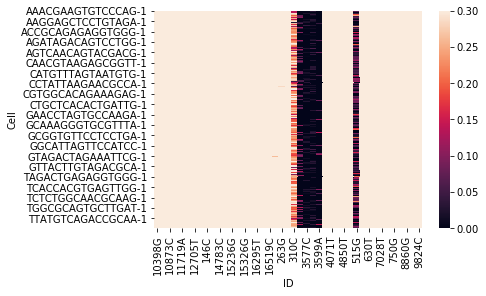

In [21]:
# 7. FILTER C: by minimum cells w heterozygous count minimum
het_filt = filter_allele_cells(ad_by_cell, het_counts_thresh, min_het_cells=min_het_cells)
af_by_cell = af_by_cell[het_filt]
ad_by_cell = ad_by_cell[het_filt]
#bq_by_cell = bq_by_cell[het_filt]
# depth_by_cell = depth_by_cell[het_filt]
# alleleDepth_by_cell = alleleDepth_by_cell[het_filt]
stats = stats.append(pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                          columns=["# Cells", "# Positions", "# Variants"],
                          index=[f"min het count {het_counts_thresh} min. het cells {min_het_cells}"]))
sns.heatmap(af_by_cell, vmin=0, vmax=0.3)
stats

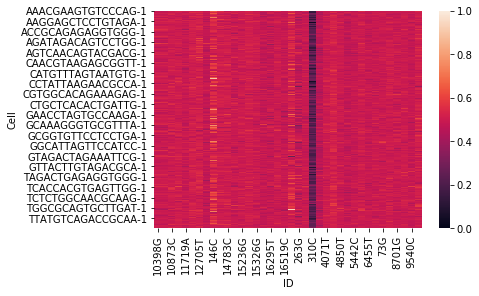

In [27]:
# 8. FILTER D: by average BQ after filtering.
bq_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns))
                    & (cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell", 
                                                          columns="ID", 
                                                          values="BQ").fillna(0)
bq_average = bq_by_cell.mean(axis=0)
bq_avg_filt = bq_by_cell.loc[:, bq_average >= bq_thresh].columns
af_by_cell = af_by_cell[bq_avg_filt]
bq_by_cell = bq_by_cell[bq_avg_filt]
ad_by_cell = ad_by_cell[bq_avg_filt]

# Create depth-by-cell
depth_by_cell = cov_ad[(cov_ad["ID"].isin(af_by_cell.columns))
                    & (cov_ad["Cell"].isin(af_by_cell.index))].pivot(index="Cell", 
                                                          columns="ID", 
                                                          values="Coverage").fillna(0)
#depth_by_cell = depth_by_cell[bq_avg_filt]
#alleleDepth_by_cell = alleleDepth_by_cell[het_filt]
stats.append(pd.DataFrame([[af_by_cell.shape[0], af_by_cell.shape[1], 0]],
                          columns=["# Cells", "# Positions", "# Variants"],
                          index=[f"BQ {bq_thresh}"]))

sns.heatmap(af_by_cell, vmin=0, vmax=1)


## Add the variant to the columns

In [23]:
# 9. Get final positions and cells.
final_cells = af_by_cell.index
final_positions = af_by_cell.columns #list(map(lambda x: int(x[:-1]), af_by_cell.columns))
print("Number of positions", len(final_positions))
print("Positions:", final_positions)

print("Number of cells", len(final_cells))

Number of positions 38
Positions: Index(['10398G', '10400T', '10873C', '11665T', '11719A', '12091C', '12705T',
       '1438G', '146C', '14766T', '14783C', '15043A', '15236G', '15301A',
       '15326G', '16223T', '16295T', '16362C', '16519C', '199C', '263G',
       '2706G', '310C', '3606G', '4071T', '4769G', '4850T', '489C', '5442C',
       '630T', '6455T', '7028T', '73G', '750G', '8701G', '8860G', '9540C',
       '9824C'],
      dtype='object', name='ID')
Number of cells 650


### Saving

In [24]:
# 10. Save files (3 diff ways)
# a. af_by_cell; depth_by_cell; bq_by_cell
# b. nt pileups: Filtered by cells and positions
# c. AF and DP sparse matrices- using our called variants
# d. Also save stats file
AF_F=None
if AF_F is not None:
    # a.
    af_by_cell.to_csv(AF_F)
    bq_by_cell.to_csv(AF_F.replace('.csv','') + ".bq.csv")
    ad_by_cell.to_csv(AF_F.replace('.csv', '') + ".AD.csv")
    depth_by_cell.to_csv(AF_F.replace('.csv', '') + ".DP.csv")
    #alleleDepth_by_cell.to_csv(AF_F.replace('.csv', '') + ".AD.csv")

    # b. Save filtered nucleotide pileups for mgatk usage
    load_and_filter_nt_pileups(concat_dir, final_cells, final_positions, os.path.dirname(AF_F), name)

    # c. Save depth and allele frequency as sparse matrices
    #af_by_cell.melt()

    # d. stats
    stats.to_csv(join(dirname(AF_F), "stats.csv"))

In [38]:
c = ax[0,0]
c.set_y

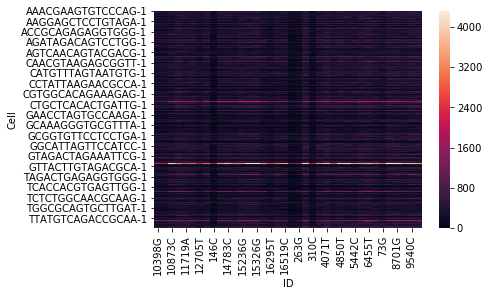

In [42]:
sns.heatmap(depth_by_cell)

Text(0.5, 0.98, 'Sqrt(allele freq), log2(allele count+1), log2(depth count+1)')

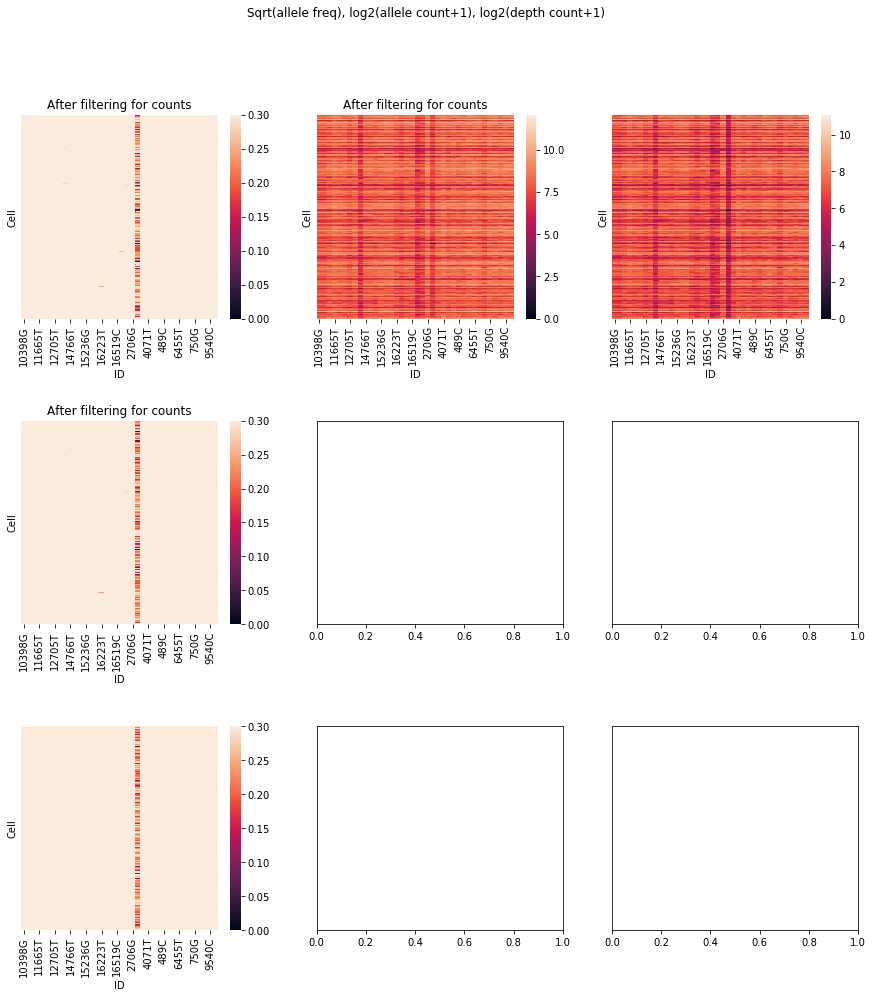

In [62]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

sns.heatmap(af_by_cell, vmin=0, vmax=0.3, ax = ax[0,0])
ax[0,0].set_title("After filtering for counts")
sns.heatmap(np.log2(depth_by_cell+1), ax = ax[0,1])
ax[0,1].set_title("After filtering for counts")
sns.heatmap(np.log2(ad_by_cell+1), ax = ax[0,2])
sns.heatmap(af_by_cell, vmin=0, vmax=0.3, ax = ax[1,0])
sns.heatmap(af_by_cell, vmin=0, vmax=0.3, ax = ax[2,0])
ax[1,0].set_title("After filtering for counts")
for curr_x in range(ax.shape[0]):
    for curr_y in range(ax.shape[1]):
        ax[curr_x, curr_y].set_yticks([])
plt.subplots_adjust(hspace=0.5)
f.suptitle("Sqrt(allele freq), log2(allele count+1), log2(depth count+1)")